In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

In [10]:
X = pd.read_csv('titanic_train.csv')

y = X['Survived']
print(X.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [11]:
def preprocess(df):
  ## Lowercase indices
  df.columns = df.columns.astype(str).str.lower()

  df['gender'] = df['sex'].map({'male':0, 'female':1})

  # bigger names = more important = survived?
  df['namelength'] = df.name.apply(lambda s: len(s))

  # get rid of string data in ticket numbers
  df['ticket'] = df.ticket.astype(str).str.rsplit(n=1)

  # remove decimals
  df['age'].fillna(df.age.mean(), inplace=True)
  df['fare'].fillna(df.fare.mean(), inplace=True)
  df['age'] = df.age.astype('int64')
  df['fare'] = df.fare.astype('int64')

  df.cabin.fillna('NONE', inplace=True)
  df['cabinType'] = df['cabin'].replace('/d+', '')
  # multiples are for families, select first for floor
  df['cabinType'] = df['cabinType'].str[0]

  # family size seems to negatively correlate with survival
  df['familySize'] = df['sibsp'] + df['parch']
  df.drop(['sibsp', 'parch'], axis=1, inplace=True)

  # categorize cabin floor 
  df.cabinType = pd.Categorical(df.cabinType)
  df['cabinCat'] = df.cabinType.cat.codes

  # categorize port
  df.embarked = pd.Categorical(df.embarked)
  df.embarked = df.embarked.cat.codes
  # 0 - C , 1 - q, 2 - s
  
  # bin age
  df['ageGroup'] = pd.cut(df.age, bins=5, labels=range(5))
    
  return df

X = preprocess(X)

In [12]:
X.drop('passengerid', axis=1, inplace=True)

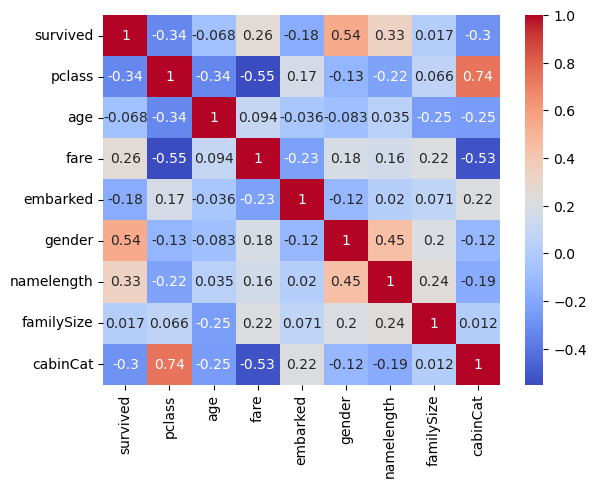

In [13]:
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)
plt.show()

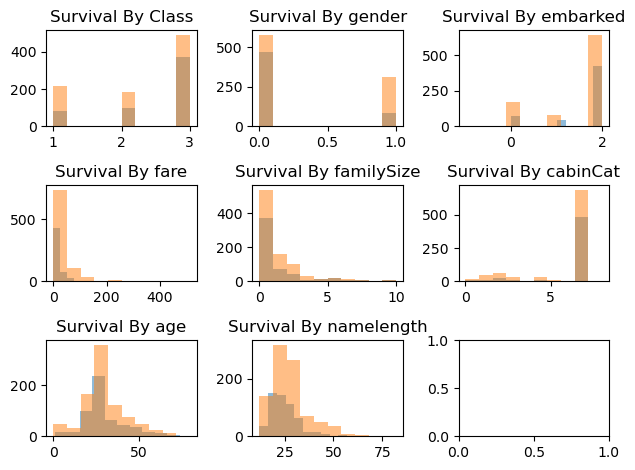

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3)

died = X[y == 0]

axs[0,0].hist(died['pclass'], alpha=0.5)
axs[0,0].hist(X['pclass'], alpha=0.5 )
axs[0,0].set_title('Survival By Class')

axs[0,1].hist(died['gender'], alpha=0.5)
axs[0,1].hist(X['gender'], alpha=0.5 )
axs[0,1].set_title('Survival By gender')

axs[0,2].hist(died['embarked'], alpha=0.5)
axs[0,2].hist(X['embarked'], alpha=0.5 )
axs[0,2].set_title('Survival By embarked')

axs[1,1].hist(died['familySize'], alpha=0.5) 
axs[1,1].hist(X['familySize'], alpha=0.5)
axs[1,1].set_title('Survival By familySize')

axs[1,2].hist(died['cabinCat'], alpha=0.5)
axs[1,2].hist(X['cabinCat'], alpha=0.5)
axs[1,2].set_title('Survival By cabinCat')

axs[1,0].hist(died['fare'], alpha=0.5)
axs[1,0].hist(X['fare'], alpha=0.5)
axs[1,0].set_title('Survival By fare')

axs[2,0].hist(died['age'], alpha=0.5)
axs[2,0].hist(X['age'], alpha=0.5)
axs[2,0].set_title('Survival By age')

axs[2,1].hist(died['namelength'], alpha=0.5)
axs[2,1].hist(X['namelength'], alpha=0.5)
axs[2,1].set_title('Survival By namelength')

plt.tight_layout()
plt.show()

In [15]:
# interesting groups
nocabin = X[X['cabin'] == 'NONE']
rich = X[X['fare'] > 100]
first = X[X['pclass'] == 1]
poor = X[X['fare'] < 10]
# b is best
bfloor = X[X['cabinCat'] == 2]
family = X[X['familySize'] > 3]

# 100% survival rate
notlucky = X[(X.cabinType == 'B') & (X.familySize < 2) & (X.gender == 1)]

# good cabins for dirt cheap, all died
c = X[X['pclass'] <= 2]
c= c[c['fare'] < 10 ]
comped = c

X.head()

,survived,pclass,name,sex,age,ticket,fare,cabin,embarked,gender,namelength,cabinType,familySize,cabinCat,ageGroup
0,0,3,"Braund, Mr. Owen Harris",male,22,"[A/5, 21171]",7,NONE,2,0,23,N,1,7,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,"[PC, 17599]",71,C85,0,1,51,C,1,2,2
2,1,3,"Heikkinen, Miss. Laina",female,26,"[STON/O2., 3101282]",7,NONE,2,1,22,N,0,7,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,[113803],53,C123,2,1,44,C,1,2,2
4,0,3,"Allen, Mr. William Henry",male,35,[373450],8,NONE,2,0,24,N,0,7,2


In [17]:
def calcSurvival(g):
    return g[g.survived==1].size /  g.size

print('nocabin', calcSurvival(nocabin))
print('rich', calcSurvival(rich))
print('firstclass', calcSurvival(first))
print('poor', calcSurvival(poor))
print('family', calcSurvival(family))
print('notlucky', calcSurvival(notlucky))
print('comped', calcSurvival(comped))
print('bfloor', calcSurvival(bfloor))

nocabin 0.29985443959243085
rich 0.7358490566037735
firstclass 0.6296296296296297
poor 0.19940476190476192
family 0.16129032258064516
notlucky 1.0
comped 0.0
bfloor 0.5932203389830508


In [18]:
y = X['survived']

# Drop Target from dataset
X.drop('survived', axis=1, inplace=True)
# remove non numbers
X = X.select_dtypes(exclude=['object'])

In [19]:
# Start
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

features = ['ageGroup','gender','cabinCat','familySize']
# note: don't replace X next time
X1 = X[features]
# X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8, random_state=42)

# # Iterate over the features and train logistic regression models
# for feat in features:
#     X_train_sub = X_train[feat]
#     X_test_sub = X_train[feat]

#     # Train a logistic regression model
#     clf = LogisticRegression(random_state=42)
#     clf.fit(X_train_sub, y_train)
    
#     # Evaluate the model on the test set
#     y_pred = clf.predict(X_test_sub)
#     acc = accuracy_score(y_test, y_pred)
    
#     # Print the results
#     print('Features:', feat)
#     print('Accuracy:', acc)
# ml setup
# features = ['age','ageGroup','gender','pclass','cabinCat','familySize','namelength','fare']

features = ['ageGroup','gender','cabinCat','familySize']
# note: don't replace X next time
X1 = X[features]

X_train, X_test, y_train, y_test = train_test_split(X1,y,train_size=.8, random_state=42)

# Define the models to try
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
#     'Support Vector Machine': SVC()
}

In [20]:
# Define the hyperparameters to tune for each model
params = {
    'Logistic Regression': {'C': [0.1, 1, 10],'random_state': [42]},
    'Decision Tree': {'max_depth': [3, 4, 5, 6, 8, 10], 'random_state': [42]},
    'k-NN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {},
    'Random Forest': {'n_estimators': [10, 50, 100], 'random_state': [42] },
#     'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

In [21]:
# Try each model and tune its hyperparameters using grid search
for name, model in models.items():
    print(f'Trying {name}')
    clf = GridSearchCV(model, params[name], cv=5)
    clf.fit(X_train, y_train)
    print(f'Best parameters: {clf.best_params_}')
    y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    print(f'Test accuracy: {accuracy:.2f}\n')

# model = DecisionTreeClassifier(random_state=42)
# model = RandomForestClassifier(n_estimators=50)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_val)

Trying Logistic Regression
Best parameters: {'C': 1, 'random_state': 42}
Test accuracy: 0.79

Trying Decision Tree
Best parameters: {'max_depth': 6, 'random_state': 42}
Test accuracy: 0.82

Trying k-NN
Best parameters: {'n_neighbors': 5}
Test accuracy: 0.80

Trying Naive Bayes
Best parameters: {}
Test accuracy: 0.79

Trying Random Forest


D:\Users\Gustavo Fortunato\anaconda3_9\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Users\Gustavo Fortunato\anaconda3_9\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

Best parameters: {'n_estimators': 10, 'random_state': 42}
Test accuracy: 0.81



In [22]:
submit = pd.DataFrame({ 'PassengerId': test_data.passengerid, 'Survived': test_pred })
print(submit)

submit.to_csv('/kaggle/working/submission.csv', index=False)

NameError: name 'test_data' is not defined